# Image Classification
In this project, you'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. You'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  You'll get to apply what you learned and build a convolutional, max pooling, dropout, and fully connected layers.  At the end, you'll get to see your neural network's predictions on the sample images.
## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explore the Data
The dataset is broken into batches to prevent your machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data.  Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

Ask yourself "What are all possible labels?", "What is the range of values for the image data?", "Are the labels in order or random?".  Answers to questions like these will help you preprocess the data and end up with better predictions.


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 10:
Image - Min Value: 24 Max Value: 130
Image - Shape: (32, 32, 3)
Label - Label Id: 4 Name: deer


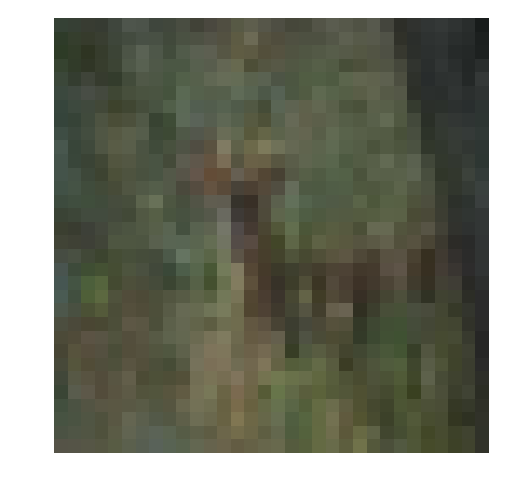

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np
import tensorflow as tf

# Explore the dataset
batch_id = 1
sample_id = 10
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
In the cell below, implement the `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [3]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    xmax, xmin = x.max(),x.min()
    y = (x-xmin)/(xmax-xmin)
    
    return y


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_normalize(normalize)

Tests Passed


### One-hot encode
Just like the previous code cell, you'll be implementing a function for preprocessing.  This time, you'll implement the `one_hot_encode` function. The input, `x`, are a list of labels.  Implement the function to return the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. The one-hot encoding function should return the same encoding for each value between each call to `one_hot_encode`.  Make sure to save the map of encodings outside the function.

**Hint:**

Look into LabelBinarizer in the preprocessing module of sklearn.

In [4]:
map = [0,1,2,3,4,5,6,7,8,9]

def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # TODO: Implement Function
    from sklearn.preprocessing import LabelBinarizer
    lb = LabelBinarizer()
    lb.fit(map)
    return lb.transform(x)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_one_hot_encode(one_hot_encode)

Tests Passed


### Randomize Data
As you saw from exploring the data above, the order of the samples are randomized.  It doesn't hurt to randomize it again, but you don't need to for this dataset.

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
This is your first checkpoint.  If you ever decide to come back to this notebook or have to restart the notebook, you can start from here.  The preprocessed data has been saved to disk.

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
For the neural network, you'll build each layer into a function.  Most of the code you've seen has been outside of functions. To test your code more thoroughly, we require that you put each layer in a function.  This allows us to give you better feedback and test for simple mistakes using our unittests before you submit your project.

>**Note:** If you're finding it hard to dedicate enough time for this course each week, we've provided a small shortcut to this part of the project. In the next couple of problems, you'll have the option to use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages to build each layer, except the layers you build in the "Convolutional and Max Pooling Layer" section.  TF Layers is similar to Keras's and TFLearn's abstraction to layers, so it's easy to pickup.

>However, if you would like to get the most out of this course, try to solve all the problems _without_ using anything from the TF Layers packages. You **can** still use classes from other packages that happen to have the same name as ones you find in TF Layers! For example, instead of using the TF Layers version of the `conv2d` class, [tf.layers.conv2d](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d), you would want to use the TF Neural Network version of `conv2d`, [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d). 

Let's begin!

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. Implement the following functions
* Implement `neural_net_image_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `image_shape` with batch size set to `None`.
 * Name the TensorFlow placeholder "x" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_label_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `n_classes` with batch size set to `None`.
 * Name the TensorFlow placeholder "y" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_keep_prob_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) for dropout keep probability.
 * Name the TensorFlow placeholder "keep_prob" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).

These names will be used at the end of the project to load your saved model.

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [7]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    # TODO: Implement Function
    shape = (None,image_shape[0],image_shape[1],image_shape[2])
    return tf.placeholder(tf.float32,shape=shape,name="x")


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    # TODO: Implement Function
    shape = [None,n_classes]
    return tf.placeholder(tf.int16,shape=shape,name="y")


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32,name="keep_prob")


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, you should implement the function `conv2d_maxpool` to apply convolution then max pooling:
* Create the weight and bias using `conv_ksize`, `conv_num_outputs` and the shape of `x_tensor`.
* Apply a convolution to `x_tensor` using weight and `conv_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.
* Add bias
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using `pool_ksize` and `pool_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.

**Note:** You **can't** use [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) for **this** layer, but you can still use TensorFlow's [Neural Network](https://www.tensorflow.org/api_docs/python/tf/nn) package. You may still use the shortcut option for all the **other** layers.

** Hint: **

When unpacking values as an argument in Python, look into the [unpacking](https://docs.python.org/3/tutorial/controlflow.html#unpacking-argument-lists) operator. 

In [8]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # TODO: Implement Function
    filter_size_width = int(conv_ksize[0])
    filter_size_height = int(conv_ksize[1])
    input_size = int(x_tensor.get_shape()[3])
#     print([filter_size_width,filter_size_height,input_size,conv_num_outputs])

    weights = tf.Variable(tf.truncated_normal(\
                                              [filter_size_width,filter_size_height,\
                                               input_size,conv_num_outputs],stddev=0.005))
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    x = tf.nn.conv2d(input=x_tensor,filter=weights,\
                            strides=[1,conv_strides[0],conv_strides[1],1],
                            padding='SAME')
    x = tf.nn.bias_add(x,bias)
    x = tf.nn.relu(x)
    
    return tf.nn.max_pool(x,ksize=[1,pool_ksize[0],pool_ksize[1],1],\
                          strides=[1,pool_strides[0],pool_strides[1],1],\
                          padding='SAME')


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_con_pool(conv2d_maxpool)

Tests Passed


### Flatten Layer
Implement the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [9]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    batch_size, dim1, dim2, dim3 = x_tensor.get_shape().as_list()
    flat_dims = dim1 * dim2 * dim3

    return tf.reshape(x_tensor,[-1, flat_dims])


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer
Implement the `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [10]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    f_size = x_tensor.get_shape().as_list()[1]
    weights = tf.Variable(tf.truncated_normal([f_size,num_outputs],stddev=0.005))
    bias = tf.Variable(tf.zeros(num_outputs))
    fc = tf.add(tf.matmul(x_tensor,weights),bias)
    
    return tf.nn.relu(fc)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer
Implement the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

**Note:** Activation, softmax, or cross entropy should **not** be applied to this.

In [11]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    size = x_tensor.get_shape().as_list()[1]
    weights = tf.Variable(tf.truncated_normal([size,num_outputs],stddev=0.005))
    bias = tf.Variable(tf.zeros(num_outputs))
    out = tf.add(tf.matmul(x_tensor,weights),bias)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_output(output)

Tests Passed


### Create Convolutional Model
Implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.  Use the layers you created above to create this model:

* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) to one or more layers in the model using `keep_prob`. 

In [12]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # TODO: Apply 1, 2, or 3 Convolution and Max Pool layers
    #    Play around with different number of outputs, kernel size and stride
    # Function Definition from Above:
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    conv_ksize = (4,4)
    conv_strides = (2,2)
    conv_num_outputs = 256
    pool_ksize = (4,4)
    pool_strides = (2,2)
    num_outputs = 10
    
    x = conv2d_maxpool(x,conv_num_outputs=conv_num_outputs,\
                       conv_ksize=conv_ksize,conv_strides=conv_strides,\
                      pool_ksize=pool_ksize,pool_strides=pool_strides)
    x = tf.nn.dropout(x,keep_prob)
    
    # TODO: Apply a Flatten Layer
    # Function Definition from Above:
    #   flatten(x_tensor)
    x = flatten(x)

    # TODO: Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputs
    # Function Definition from Above:
    #   fully_conn(x_tensor, num_outputs)
    x = fully_conn(x,num_outputs)
    x = tf.nn.dropout(x,keep_prob)
    # TODO: Apply an Output Layer
    #    Set this to the number of classes
    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    
    # TODO: return output
    return output(x,num_outputs)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network
### Single Optimization
Implement the function `train_neural_network` to do a single optimization.  The optimization should use `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [13]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # TODO: Implement Function
    session.run(optimizer,feed_dict={x:feature_batch,y:label_batch,keep_prob:keep_probability})
    pass


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_train_nn(train_neural_network)

Tests Passed


### Show Stats
Implement the function `print_stats` to print loss and validation accuracy.  Use the global variables `valid_features` and `valid_labels` to calculate validation accuracy.  Use a keep probability of `1.0` to calculate the loss and validation accuracy.

In [14]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    # TODO: Implement Function
    loss = session.run(cost,{x:feature_batch,y:label_batch,keep_prob:1.})
    valid_acc = session.run(accuracy,{x:valid_features,y:valid_labels,keep_prob:1.})
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss,valid_acc))
    pass

### Hyperparameters
Tune the following parameters:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number that your machine has memory for.  Most people set them to common sizes of memory:
 * 64
 * 128
 * 256
 * ...
* Set `keep_probability` to the probability of keeping a node using dropout

In [15]:
# TODO: Tune Parameters
epochs = 600
batch_size = 1024
keep_probability = 0.8

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while you iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [56]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.3026 Validation Accuracy: 0.098800
Epoch  2, CIFAR-10 Batch 1:  Loss:     2.3024 Validation Accuracy: 0.105000
Epoch  3, CIFAR-10 Batch 1:  Loss:     2.3021 Validation Accuracy: 0.105000
Epoch  4, CIFAR-10 Batch 1:  Loss:     2.3015 Validation Accuracy: 0.105000
Epoch  5, CIFAR-10 Batch 1:  Loss:     2.3006 Validation Accuracy: 0.105000
Epoch  6, CIFAR-10 Batch 1:  Loss:     2.2990 Validation Accuracy: 0.105000
Epoch  7, CIFAR-10 Batch 1:  Loss:     2.2971 Validation Accuracy: 0.105000
Epoch  8, CIFAR-10 Batch 1:  Loss:     2.2946 Validation Accuracy: 0.105000
Epoch  9, CIFAR-10 Batch 1:  Loss:     2.2915 Validation Accuracy: 0.105400
Epoch 10, CIFAR-10 Batch 1:  Loss:     2.2874 Validation Accuracy: 0.105600
Epoch 11, CIFAR-10 Batch 1:  Loss:     2.2823 Validation Accuracy: 0.108600
Epoch 12, CIFAR-10 Batch 1:  Loss:     2.2758 Validation Accuracy: 0.112000
Epoch 13, CIFAR-10 Batch 1:  Loss:     2.2677

### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.2925 Validation Accuracy: 0.105000
Epoch  1, CIFAR-10 Batch 2:  Loss:     2.2427 Validation Accuracy: 0.153800
Epoch  1, CIFAR-10 Batch 3:  Loss:     2.1389 Validation Accuracy: 0.189400
Epoch  1, CIFAR-10 Batch 4:  Loss:     2.0837 Validation Accuracy: 0.204000
Epoch  1, CIFAR-10 Batch 5:  Loss:     2.0443 Validation Accuracy: 0.236800
Epoch  2, CIFAR-10 Batch 1:  Loss:     2.0525 Validation Accuracy: 0.241000
Epoch  2, CIFAR-10 Batch 2:  Loss:     2.0300 Validation Accuracy: 0.241800
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.9450 Validation Accuracy: 0.252000
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.9545 Validation Accuracy: 0.261800
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.9303 Validation Accuracy: 0.278400
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.9504 Validation Accuracy: 0.270400
Epoch  3, CIFAR-10 Batch 2:  Loss:     1.9081 Validation Accuracy: 0.303600
Epoch  3, CIFAR-10 Batch 3:  Loss:     1.8190 Validation Accuracy: 0.312600


Epoch 22, CIFAR-10 Batch 4:  Loss:     1.3471 Validation Accuracy: 0.510400
Epoch 22, CIFAR-10 Batch 5:  Loss:     1.3616 Validation Accuracy: 0.503400
Epoch 23, CIFAR-10 Batch 1:  Loss:     1.3317 Validation Accuracy: 0.511800
Epoch 23, CIFAR-10 Batch 2:  Loss:     1.3514 Validation Accuracy: 0.512200
Epoch 23, CIFAR-10 Batch 3:  Loss:     1.2995 Validation Accuracy: 0.506000
Epoch 23, CIFAR-10 Batch 4:  Loss:     1.3444 Validation Accuracy: 0.514400
Epoch 23, CIFAR-10 Batch 5:  Loss:     1.3328 Validation Accuracy: 0.514800
Epoch 24, CIFAR-10 Batch 1:  Loss:     1.3367 Validation Accuracy: 0.516200
Epoch 24, CIFAR-10 Batch 2:  Loss:     1.3426 Validation Accuracy: 0.509600
Epoch 24, CIFAR-10 Batch 3:  Loss:     1.3135 Validation Accuracy: 0.504400
Epoch 24, CIFAR-10 Batch 4:  Loss:     1.3265 Validation Accuracy: 0.518800
Epoch 24, CIFAR-10 Batch 5:  Loss:     1.3245 Validation Accuracy: 0.514600
Epoch 25, CIFAR-10 Batch 1:  Loss:     1.3256 Validation Accuracy: 0.515200
Epoch 25, CI

Epoch 44, CIFAR-10 Batch 2:  Loss:     1.1572 Validation Accuracy: 0.566200
Epoch 44, CIFAR-10 Batch 3:  Loss:     1.1505 Validation Accuracy: 0.564400
Epoch 44, CIFAR-10 Batch 4:  Loss:     1.1467 Validation Accuracy: 0.570200
Epoch 44, CIFAR-10 Batch 5:  Loss:     1.1777 Validation Accuracy: 0.566400
Epoch 45, CIFAR-10 Batch 1:  Loss:     1.1839 Validation Accuracy: 0.574400
Epoch 45, CIFAR-10 Batch 2:  Loss:     1.1555 Validation Accuracy: 0.573200
Epoch 45, CIFAR-10 Batch 3:  Loss:     1.1305 Validation Accuracy: 0.567000
Epoch 45, CIFAR-10 Batch 4:  Loss:     1.1439 Validation Accuracy: 0.572400
Epoch 45, CIFAR-10 Batch 5:  Loss:     1.1510 Validation Accuracy: 0.571800
Epoch 46, CIFAR-10 Batch 1:  Loss:     1.1795 Validation Accuracy: 0.570200
Epoch 46, CIFAR-10 Batch 2:  Loss:     1.1473 Validation Accuracy: 0.572800
Epoch 46, CIFAR-10 Batch 3:  Loss:     1.1403 Validation Accuracy: 0.570800
Epoch 46, CIFAR-10 Batch 4:  Loss:     1.1356 Validation Accuracy: 0.574000
Epoch 46, CI

Epoch 65, CIFAR-10 Batch 5:  Loss:     1.0595 Validation Accuracy: 0.604600
Epoch 66, CIFAR-10 Batch 1:  Loss:     1.0997 Validation Accuracy: 0.603000
Epoch 66, CIFAR-10 Batch 2:  Loss:     1.0447 Validation Accuracy: 0.598800
Epoch 66, CIFAR-10 Batch 3:  Loss:     1.0618 Validation Accuracy: 0.595200
Epoch 66, CIFAR-10 Batch 4:  Loss:     1.0573 Validation Accuracy: 0.601000
Epoch 66, CIFAR-10 Batch 5:  Loss:     1.0694 Validation Accuracy: 0.602600
Epoch 67, CIFAR-10 Batch 1:  Loss:     1.0937 Validation Accuracy: 0.606600
Epoch 67, CIFAR-10 Batch 2:  Loss:     1.0395 Validation Accuracy: 0.598400
Epoch 67, CIFAR-10 Batch 3:  Loss:     1.0542 Validation Accuracy: 0.596200
Epoch 67, CIFAR-10 Batch 4:  Loss:     1.0482 Validation Accuracy: 0.597800
Epoch 67, CIFAR-10 Batch 5:  Loss:     1.0557 Validation Accuracy: 0.611200
Epoch 68, CIFAR-10 Batch 1:  Loss:     1.0865 Validation Accuracy: 0.607200
Epoch 68, CIFAR-10 Batch 2:  Loss:     1.0434 Validation Accuracy: 0.601600
Epoch 68, CI

Epoch 87, CIFAR-10 Batch 3:  Loss:     0.9841 Validation Accuracy: 0.616800
Epoch 87, CIFAR-10 Batch 4:  Loss:     0.9855 Validation Accuracy: 0.614000
Epoch 87, CIFAR-10 Batch 5:  Loss:     0.9817 Validation Accuracy: 0.618800
Epoch 88, CIFAR-10 Batch 1:  Loss:     1.0395 Validation Accuracy: 0.620200
Epoch 88, CIFAR-10 Batch 2:  Loss:     0.9857 Validation Accuracy: 0.620200
Epoch 88, CIFAR-10 Batch 3:  Loss:     0.9796 Validation Accuracy: 0.615800
Epoch 88, CIFAR-10 Batch 4:  Loss:     0.9737 Validation Accuracy: 0.617000
Epoch 88, CIFAR-10 Batch 5:  Loss:     0.9763 Validation Accuracy: 0.624600
Epoch 89, CIFAR-10 Batch 1:  Loss:     1.0309 Validation Accuracy: 0.620800
Epoch 89, CIFAR-10 Batch 2:  Loss:     0.9846 Validation Accuracy: 0.617200
Epoch 89, CIFAR-10 Batch 3:  Loss:     0.9772 Validation Accuracy: 0.619400
Epoch 89, CIFAR-10 Batch 4:  Loss:     0.9771 Validation Accuracy: 0.612800
Epoch 89, CIFAR-10 Batch 5:  Loss:     0.9763 Validation Accuracy: 0.621800
Epoch 90, CI

Epoch 130, CIFAR-10 Batch 2:  Loss:     0.8809 Validation Accuracy: 0.640200
Epoch 130, CIFAR-10 Batch 3:  Loss:     0.8964 Validation Accuracy: 0.637000
Epoch 130, CIFAR-10 Batch 4:  Loss:     0.8749 Validation Accuracy: 0.632200
Epoch 130, CIFAR-10 Batch 5:  Loss:     0.8849 Validation Accuracy: 0.634200
Epoch 131, CIFAR-10 Batch 1:  Loss:     0.9289 Validation Accuracy: 0.636400
Epoch 131, CIFAR-10 Batch 2:  Loss:     0.8942 Validation Accuracy: 0.641000
Epoch 131, CIFAR-10 Batch 3:  Loss:     0.8707 Validation Accuracy: 0.640200
Epoch 131, CIFAR-10 Batch 4:  Loss:     0.8868 Validation Accuracy: 0.634200
Epoch 131, CIFAR-10 Batch 5:  Loss:     0.8632 Validation Accuracy: 0.644600
Epoch 132, CIFAR-10 Batch 1:  Loss:     0.9148 Validation Accuracy: 0.643000
Epoch 132, CIFAR-10 Batch 2:  Loss:     0.8843 Validation Accuracy: 0.642800
Epoch 132, CIFAR-10 Batch 3:  Loss:     0.8691 Validation Accuracy: 0.642400
Epoch 132, CIFAR-10 Batch 4:  Loss:     0.8616 Validation Accuracy: 0.640800

Epoch 151, CIFAR-10 Batch 4:  Loss:     0.8220 Validation Accuracy: 0.651800
Epoch 151, CIFAR-10 Batch 5:  Loss:     0.8278 Validation Accuracy: 0.643400
Epoch 152, CIFAR-10 Batch 1:  Loss:     0.8795 Validation Accuracy: 0.643000
Epoch 152, CIFAR-10 Batch 2:  Loss:     0.8445 Validation Accuracy: 0.647800
Epoch 152, CIFAR-10 Batch 3:  Loss:     0.8434 Validation Accuracy: 0.653400
Epoch 152, CIFAR-10 Batch 4:  Loss:     0.8124 Validation Accuracy: 0.648400
Epoch 152, CIFAR-10 Batch 5:  Loss:     0.8372 Validation Accuracy: 0.646200
Epoch 153, CIFAR-10 Batch 1:  Loss:     0.8686 Validation Accuracy: 0.651400
Epoch 153, CIFAR-10 Batch 2:  Loss:     0.8356 Validation Accuracy: 0.650200
Epoch 153, CIFAR-10 Batch 3:  Loss:     0.8296 Validation Accuracy: 0.653400
Epoch 153, CIFAR-10 Batch 4:  Loss:     0.8148 Validation Accuracy: 0.651200
Epoch 153, CIFAR-10 Batch 5:  Loss:     0.8351 Validation Accuracy: 0.646800
Epoch 154, CIFAR-10 Batch 1:  Loss:     0.8499 Validation Accuracy: 0.652600

Epoch 173, CIFAR-10 Batch 1:  Loss:     0.8222 Validation Accuracy: 0.661200
Epoch 173, CIFAR-10 Batch 2:  Loss:     0.8108 Validation Accuracy: 0.655200
Epoch 173, CIFAR-10 Batch 3:  Loss:     0.8130 Validation Accuracy: 0.655000
Epoch 173, CIFAR-10 Batch 4:  Loss:     0.7769 Validation Accuracy: 0.660400
Epoch 173, CIFAR-10 Batch 5:  Loss:     0.8002 Validation Accuracy: 0.661800
Epoch 174, CIFAR-10 Batch 1:  Loss:     0.8143 Validation Accuracy: 0.661000
Epoch 174, CIFAR-10 Batch 2:  Loss:     0.7995 Validation Accuracy: 0.655600
Epoch 174, CIFAR-10 Batch 3:  Loss:     0.8090 Validation Accuracy: 0.654800
Epoch 174, CIFAR-10 Batch 4:  Loss:     0.7730 Validation Accuracy: 0.653000
Epoch 174, CIFAR-10 Batch 5:  Loss:     0.7839 Validation Accuracy: 0.659000
Epoch 175, CIFAR-10 Batch 1:  Loss:     0.8197 Validation Accuracy: 0.655600
Epoch 175, CIFAR-10 Batch 2:  Loss:     0.8038 Validation Accuracy: 0.655400
Epoch 175, CIFAR-10 Batch 3:  Loss:     0.8156 Validation Accuracy: 0.650800

Epoch 194, CIFAR-10 Batch 3:  Loss:     0.7843 Validation Accuracy: 0.655600
Epoch 194, CIFAR-10 Batch 4:  Loss:     0.7449 Validation Accuracy: 0.659600
Epoch 194, CIFAR-10 Batch 5:  Loss:     0.7712 Validation Accuracy: 0.657600
Epoch 195, CIFAR-10 Batch 1:  Loss:     0.7941 Validation Accuracy: 0.660000
Epoch 195, CIFAR-10 Batch 2:  Loss:     0.7836 Validation Accuracy: 0.655000
Epoch 195, CIFAR-10 Batch 3:  Loss:     0.7763 Validation Accuracy: 0.662800
Epoch 195, CIFAR-10 Batch 4:  Loss:     0.7407 Validation Accuracy: 0.666600
Epoch 195, CIFAR-10 Batch 5:  Loss:     0.7687 Validation Accuracy: 0.656200
Epoch 196, CIFAR-10 Batch 1:  Loss:     0.7884 Validation Accuracy: 0.658800
Epoch 196, CIFAR-10 Batch 2:  Loss:     0.7772 Validation Accuracy: 0.658200
Epoch 196, CIFAR-10 Batch 3:  Loss:     0.7856 Validation Accuracy: 0.656600
Epoch 196, CIFAR-10 Batch 4:  Loss:     0.7469 Validation Accuracy: 0.659000
Epoch 196, CIFAR-10 Batch 5:  Loss:     0.7515 Validation Accuracy: 0.662000

Epoch 215, CIFAR-10 Batch 5:  Loss:     0.7252 Validation Accuracy: 0.666800
Epoch 216, CIFAR-10 Batch 1:  Loss:     0.7517 Validation Accuracy: 0.668400
Epoch 216, CIFAR-10 Batch 2:  Loss:     0.7377 Validation Accuracy: 0.665000
Epoch 216, CIFAR-10 Batch 3:  Loss:     0.7633 Validation Accuracy: 0.662600
Epoch 216, CIFAR-10 Batch 4:  Loss:     0.7156 Validation Accuracy: 0.669800
Epoch 216, CIFAR-10 Batch 5:  Loss:     0.7326 Validation Accuracy: 0.663000
Epoch 217, CIFAR-10 Batch 1:  Loss:     0.7504 Validation Accuracy: 0.669600
Epoch 217, CIFAR-10 Batch 2:  Loss:     0.7503 Validation Accuracy: 0.655800
Epoch 217, CIFAR-10 Batch 3:  Loss:     0.7788 Validation Accuracy: 0.661000
Epoch 217, CIFAR-10 Batch 4:  Loss:     0.7103 Validation Accuracy: 0.662800
Epoch 217, CIFAR-10 Batch 5:  Loss:     0.7200 Validation Accuracy: 0.668200
Epoch 218, CIFAR-10 Batch 1:  Loss:     0.7642 Validation Accuracy: 0.664800
Epoch 218, CIFAR-10 Batch 2:  Loss:     0.7585 Validation Accuracy: 0.662000

Epoch 237, CIFAR-10 Batch 2:  Loss:     0.7249 Validation Accuracy: 0.658200
Epoch 237, CIFAR-10 Batch 3:  Loss:     0.7384 Validation Accuracy: 0.659200
Epoch 237, CIFAR-10 Batch 4:  Loss:     0.6819 Validation Accuracy: 0.667600
Epoch 237, CIFAR-10 Batch 5:  Loss:     0.7074 Validation Accuracy: 0.664200
Epoch 238, CIFAR-10 Batch 1:  Loss:     0.7338 Validation Accuracy: 0.664000
Epoch 238, CIFAR-10 Batch 2:  Loss:     0.7107 Validation Accuracy: 0.664400
Epoch 238, CIFAR-10 Batch 3:  Loss:     0.7206 Validation Accuracy: 0.665000
Epoch 238, CIFAR-10 Batch 4:  Loss:     0.6763 Validation Accuracy: 0.672400
Epoch 238, CIFAR-10 Batch 5:  Loss:     0.7072 Validation Accuracy: 0.665800
Epoch 239, CIFAR-10 Batch 1:  Loss:     0.7330 Validation Accuracy: 0.666000
Epoch 239, CIFAR-10 Batch 2:  Loss:     0.7110 Validation Accuracy: 0.665600
Epoch 239, CIFAR-10 Batch 3:  Loss:     0.7112 Validation Accuracy: 0.668800
Epoch 239, CIFAR-10 Batch 4:  Loss:     0.6720 Validation Accuracy: 0.669600

Epoch 258, CIFAR-10 Batch 4:  Loss:     0.6750 Validation Accuracy: 0.667600
Epoch 258, CIFAR-10 Batch 5:  Loss:     0.6847 Validation Accuracy: 0.674800
Epoch 259, CIFAR-10 Batch 1:  Loss:     0.7042 Validation Accuracy: 0.665400
Epoch 259, CIFAR-10 Batch 2:  Loss:     0.6912 Validation Accuracy: 0.659600
Epoch 259, CIFAR-10 Batch 3:  Loss:     0.6946 Validation Accuracy: 0.663200
Epoch 259, CIFAR-10 Batch 4:  Loss:     0.6610 Validation Accuracy: 0.665200
Epoch 259, CIFAR-10 Batch 5:  Loss:     0.7007 Validation Accuracy: 0.661800
Epoch 260, CIFAR-10 Batch 1:  Loss:     0.7081 Validation Accuracy: 0.670400
Epoch 260, CIFAR-10 Batch 2:  Loss:     0.6929 Validation Accuracy: 0.663800
Epoch 260, CIFAR-10 Batch 3:  Loss:     0.6869 Validation Accuracy: 0.662200
Epoch 260, CIFAR-10 Batch 4:  Loss:     0.6729 Validation Accuracy: 0.657200
Epoch 260, CIFAR-10 Batch 5:  Loss:     0.6918 Validation Accuracy: 0.663800
Epoch 261, CIFAR-10 Batch 1:  Loss:     0.7309 Validation Accuracy: 0.657400

Epoch 280, CIFAR-10 Batch 1:  Loss:     0.6638 Validation Accuracy: 0.668600
Epoch 280, CIFAR-10 Batch 2:  Loss:     0.6834 Validation Accuracy: 0.667600
Epoch 280, CIFAR-10 Batch 3:  Loss:     0.6927 Validation Accuracy: 0.659400
Epoch 280, CIFAR-10 Batch 4:  Loss:     0.6701 Validation Accuracy: 0.653600
Epoch 280, CIFAR-10 Batch 5:  Loss:     0.6705 Validation Accuracy: 0.666400
Epoch 281, CIFAR-10 Batch 1:  Loss:     0.6857 Validation Accuracy: 0.669800
Epoch 281, CIFAR-10 Batch 2:  Loss:     0.6776 Validation Accuracy: 0.668600
Epoch 281, CIFAR-10 Batch 3:  Loss:     0.6630 Validation Accuracy: 0.671000
Epoch 281, CIFAR-10 Batch 4:  Loss:     0.6487 Validation Accuracy: 0.660200
Epoch 281, CIFAR-10 Batch 5:  Loss:     0.6792 Validation Accuracy: 0.661400
Epoch 282, CIFAR-10 Batch 1:  Loss:     0.6938 Validation Accuracy: 0.668600
Epoch 282, CIFAR-10 Batch 2:  Loss:     0.6841 Validation Accuracy: 0.670800
Epoch 282, CIFAR-10 Batch 3:  Loss:     0.6803 Validation Accuracy: 0.669600

Epoch 301, CIFAR-10 Batch 3:  Loss:     0.6521 Validation Accuracy: 0.668800
Epoch 301, CIFAR-10 Batch 4:  Loss:     0.6204 Validation Accuracy: 0.665200
Epoch 301, CIFAR-10 Batch 5:  Loss:     0.6426 Validation Accuracy: 0.670400
Epoch 302, CIFAR-10 Batch 1:  Loss:     0.6574 Validation Accuracy: 0.669200
Epoch 302, CIFAR-10 Batch 2:  Loss:     0.6581 Validation Accuracy: 0.672000
Epoch 302, CIFAR-10 Batch 3:  Loss:     0.6564 Validation Accuracy: 0.668000
Epoch 302, CIFAR-10 Batch 4:  Loss:     0.6240 Validation Accuracy: 0.667400
Epoch 302, CIFAR-10 Batch 5:  Loss:     0.6315 Validation Accuracy: 0.673000
Epoch 303, CIFAR-10 Batch 1:  Loss:     0.6595 Validation Accuracy: 0.673400
Epoch 303, CIFAR-10 Batch 2:  Loss:     0.6587 Validation Accuracy: 0.673000
Epoch 303, CIFAR-10 Batch 3:  Loss:     0.6419 Validation Accuracy: 0.672400
Epoch 303, CIFAR-10 Batch 4:  Loss:     0.6008 Validation Accuracy: 0.667800
Epoch 303, CIFAR-10 Batch 5:  Loss:     0.6316 Validation Accuracy: 0.669800

Epoch 322, CIFAR-10 Batch 5:  Loss:     0.6242 Validation Accuracy: 0.662200
Epoch 323, CIFAR-10 Batch 1:  Loss:     0.6573 Validation Accuracy: 0.664400
Epoch 323, CIFAR-10 Batch 2:  Loss:     0.6542 Validation Accuracy: 0.668600
Epoch 323, CIFAR-10 Batch 3:  Loss:     0.6273 Validation Accuracy: 0.671600
Epoch 323, CIFAR-10 Batch 4:  Loss:     0.5986 Validation Accuracy: 0.670000
Epoch 323, CIFAR-10 Batch 5:  Loss:     0.6245 Validation Accuracy: 0.671800
Epoch 324, CIFAR-10 Batch 1:  Loss:     0.6287 Validation Accuracy: 0.676800
Epoch 324, CIFAR-10 Batch 2:  Loss:     0.6433 Validation Accuracy: 0.664200
Epoch 324, CIFAR-10 Batch 3:  Loss:     0.6417 Validation Accuracy: 0.664800
Epoch 324, CIFAR-10 Batch 4:  Loss:     0.6045 Validation Accuracy: 0.666200
Epoch 324, CIFAR-10 Batch 5:  Loss:     0.6465 Validation Accuracy: 0.661400
Epoch 325, CIFAR-10 Batch 1:  Loss:     0.6654 Validation Accuracy: 0.660600
Epoch 325, CIFAR-10 Batch 2:  Loss:     0.6414 Validation Accuracy: 0.669600

Epoch 344, CIFAR-10 Batch 2:  Loss:     0.6824 Validation Accuracy: 0.657000
Epoch 344, CIFAR-10 Batch 3:  Loss:     0.6027 Validation Accuracy: 0.679200
Epoch 344, CIFAR-10 Batch 4:  Loss:     0.6051 Validation Accuracy: 0.661600
Epoch 344, CIFAR-10 Batch 5:  Loss:     0.6218 Validation Accuracy: 0.668200
Epoch 345, CIFAR-10 Batch 1:  Loss:     0.6480 Validation Accuracy: 0.664600
Epoch 345, CIFAR-10 Batch 2:  Loss:     0.6366 Validation Accuracy: 0.671600
Epoch 345, CIFAR-10 Batch 3:  Loss:     0.6298 Validation Accuracy: 0.669400
Epoch 345, CIFAR-10 Batch 4:  Loss:     0.6149 Validation Accuracy: 0.661600
Epoch 345, CIFAR-10 Batch 5:  Loss:     0.6146 Validation Accuracy: 0.667400
Epoch 346, CIFAR-10 Batch 1:  Loss:     0.6401 Validation Accuracy: 0.670600
Epoch 346, CIFAR-10 Batch 2:  Loss:     0.6114 Validation Accuracy: 0.673800
Epoch 346, CIFAR-10 Batch 3:  Loss:     0.6149 Validation Accuracy: 0.675200
Epoch 346, CIFAR-10 Batch 4:  Loss:     0.6138 Validation Accuracy: 0.656600

Epoch 365, CIFAR-10 Batch 4:  Loss:     0.5758 Validation Accuracy: 0.673400
Epoch 365, CIFAR-10 Batch 5:  Loss:     0.5938 Validation Accuracy: 0.665400
Epoch 366, CIFAR-10 Batch 1:  Loss:     0.6299 Validation Accuracy: 0.672200
Epoch 366, CIFAR-10 Batch 2:  Loss:     0.6019 Validation Accuracy: 0.673000
Epoch 366, CIFAR-10 Batch 3:  Loss:     0.6217 Validation Accuracy: 0.670600
Epoch 366, CIFAR-10 Batch 4:  Loss:     0.5688 Validation Accuracy: 0.668800
Epoch 366, CIFAR-10 Batch 5:  Loss:     0.5727 Validation Accuracy: 0.669000
Epoch 367, CIFAR-10 Batch 1:  Loss:     0.6277 Validation Accuracy: 0.673000
Epoch 367, CIFAR-10 Batch 2:  Loss:     0.6280 Validation Accuracy: 0.659400
Epoch 367, CIFAR-10 Batch 3:  Loss:     0.6276 Validation Accuracy: 0.663600
Epoch 367, CIFAR-10 Batch 4:  Loss:     0.5682 Validation Accuracy: 0.667200
Epoch 367, CIFAR-10 Batch 5:  Loss:     0.5983 Validation Accuracy: 0.656000
Epoch 368, CIFAR-10 Batch 1:  Loss:     0.6171 Validation Accuracy: 0.673200

Epoch 387, CIFAR-10 Batch 1:  Loss:     0.6061 Validation Accuracy: 0.670800
Epoch 387, CIFAR-10 Batch 2:  Loss:     0.6224 Validation Accuracy: 0.667600
Epoch 387, CIFAR-10 Batch 3:  Loss:     0.5945 Validation Accuracy: 0.673800
Epoch 387, CIFAR-10 Batch 4:  Loss:     0.5450 Validation Accuracy: 0.672200
Epoch 387, CIFAR-10 Batch 5:  Loss:     0.5729 Validation Accuracy: 0.671800
Epoch 388, CIFAR-10 Batch 1:  Loss:     0.5974 Validation Accuracy: 0.667600
Epoch 388, CIFAR-10 Batch 2:  Loss:     0.5937 Validation Accuracy: 0.674600
Epoch 388, CIFAR-10 Batch 3:  Loss:     0.5818 Validation Accuracy: 0.674200
Epoch 388, CIFAR-10 Batch 4:  Loss:     0.5631 Validation Accuracy: 0.668000
Epoch 388, CIFAR-10 Batch 5:  Loss:     0.5742 Validation Accuracy: 0.661800
Epoch 389, CIFAR-10 Batch 1:  Loss:     0.5979 Validation Accuracy: 0.671200
Epoch 389, CIFAR-10 Batch 2:  Loss:     0.6161 Validation Accuracy: 0.670800
Epoch 389, CIFAR-10 Batch 3:  Loss:     0.5938 Validation Accuracy: 0.674800

Epoch 408, CIFAR-10 Batch 3:  Loss:     0.5948 Validation Accuracy: 0.676200
Epoch 408, CIFAR-10 Batch 4:  Loss:     0.5295 Validation Accuracy: 0.672000
Epoch 408, CIFAR-10 Batch 5:  Loss:     0.5566 Validation Accuracy: 0.672600
Epoch 409, CIFAR-10 Batch 1:  Loss:     0.5836 Validation Accuracy: 0.672200
Epoch 409, CIFAR-10 Batch 2:  Loss:     0.5863 Validation Accuracy: 0.675600
Epoch 409, CIFAR-10 Batch 3:  Loss:     0.5767 Validation Accuracy: 0.673400
Epoch 409, CIFAR-10 Batch 4:  Loss:     0.5325 Validation Accuracy: 0.667400
Epoch 409, CIFAR-10 Batch 5:  Loss:     0.5754 Validation Accuracy: 0.668400
Epoch 410, CIFAR-10 Batch 1:  Loss:     0.5871 Validation Accuracy: 0.667600
Epoch 410, CIFAR-10 Batch 2:  Loss:     0.5970 Validation Accuracy: 0.668200
Epoch 410, CIFAR-10 Batch 3:  Loss:     0.5909 Validation Accuracy: 0.677800
Epoch 410, CIFAR-10 Batch 4:  Loss:     0.5363 Validation Accuracy: 0.679800
Epoch 410, CIFAR-10 Batch 5:  Loss:     0.5714 Validation Accuracy: 0.666200

Epoch 429, CIFAR-10 Batch 5:  Loss:     0.5687 Validation Accuracy: 0.667400
Epoch 430, CIFAR-10 Batch 1:  Loss:     0.6061 Validation Accuracy: 0.667200
Epoch 430, CIFAR-10 Batch 2:  Loss:     0.5886 Validation Accuracy: 0.670400
Epoch 430, CIFAR-10 Batch 3:  Loss:     0.5792 Validation Accuracy: 0.668800
Epoch 430, CIFAR-10 Batch 4:  Loss:     0.5445 Validation Accuracy: 0.667600
Epoch 430, CIFAR-10 Batch 5:  Loss:     0.5588 Validation Accuracy: 0.670800
Epoch 431, CIFAR-10 Batch 1:  Loss:     0.5844 Validation Accuracy: 0.663400
Epoch 431, CIFAR-10 Batch 2:  Loss:     0.5978 Validation Accuracy: 0.669200
Epoch 431, CIFAR-10 Batch 3:  Loss:     0.5872 Validation Accuracy: 0.668600
Epoch 431, CIFAR-10 Batch 4:  Loss:     0.5237 Validation Accuracy: 0.666400
Epoch 431, CIFAR-10 Batch 5:  Loss:     0.5746 Validation Accuracy: 0.664000
Epoch 432, CIFAR-10 Batch 1:  Loss:     0.5797 Validation Accuracy: 0.668800
Epoch 432, CIFAR-10 Batch 2:  Loss:     0.5746 Validation Accuracy: 0.671400

Epoch 451, CIFAR-10 Batch 2:  Loss:     0.6334 Validation Accuracy: 0.658400
Epoch 451, CIFAR-10 Batch 3:  Loss:     0.5916 Validation Accuracy: 0.662000
Epoch 451, CIFAR-10 Batch 4:  Loss:     0.5596 Validation Accuracy: 0.663400
Epoch 451, CIFAR-10 Batch 5:  Loss:     0.6121 Validation Accuracy: 0.640800
Epoch 452, CIFAR-10 Batch 1:  Loss:     0.6179 Validation Accuracy: 0.657400
Epoch 452, CIFAR-10 Batch 2:  Loss:     0.6269 Validation Accuracy: 0.654000
Epoch 452, CIFAR-10 Batch 3:  Loss:     0.5943 Validation Accuracy: 0.658000
Epoch 452, CIFAR-10 Batch 4:  Loss:     0.5701 Validation Accuracy: 0.658400
Epoch 452, CIFAR-10 Batch 5:  Loss:     0.5904 Validation Accuracy: 0.657200
Epoch 453, CIFAR-10 Batch 1:  Loss:     0.6077 Validation Accuracy: 0.667200
Epoch 453, CIFAR-10 Batch 2:  Loss:     0.6059 Validation Accuracy: 0.660200
Epoch 453, CIFAR-10 Batch 3:  Loss:     0.5704 Validation Accuracy: 0.665800
Epoch 453, CIFAR-10 Batch 4:  Loss:     0.5589 Validation Accuracy: 0.664400

Epoch 472, CIFAR-10 Batch 4:  Loss:     0.5812 Validation Accuracy: 0.665200
Epoch 472, CIFAR-10 Batch 5:  Loss:     0.5539 Validation Accuracy: 0.662000
Epoch 473, CIFAR-10 Batch 1:  Loss:     0.5918 Validation Accuracy: 0.668200
Epoch 473, CIFAR-10 Batch 2:  Loss:     0.5865 Validation Accuracy: 0.666600
Epoch 473, CIFAR-10 Batch 3:  Loss:     0.5467 Validation Accuracy: 0.676400
Epoch 473, CIFAR-10 Batch 4:  Loss:     0.5580 Validation Accuracy: 0.671400
Epoch 473, CIFAR-10 Batch 5:  Loss:     0.5440 Validation Accuracy: 0.666800
Epoch 474, CIFAR-10 Batch 1:  Loss:     0.5682 Validation Accuracy: 0.670800
Epoch 474, CIFAR-10 Batch 2:  Loss:     0.5649 Validation Accuracy: 0.665200
Epoch 474, CIFAR-10 Batch 3:  Loss:     0.5717 Validation Accuracy: 0.668800
Epoch 474, CIFAR-10 Batch 4:  Loss:     0.5503 Validation Accuracy: 0.671600
Epoch 474, CIFAR-10 Batch 5:  Loss:     0.5313 Validation Accuracy: 0.667200
Epoch 475, CIFAR-10 Batch 1:  Loss:     0.5626 Validation Accuracy: 0.670600

Epoch 494, CIFAR-10 Batch 1:  Loss:     0.5573 Validation Accuracy: 0.671400
Epoch 494, CIFAR-10 Batch 2:  Loss:     0.5444 Validation Accuracy: 0.672800
Epoch 494, CIFAR-10 Batch 3:  Loss:     0.5398 Validation Accuracy: 0.677200
Epoch 494, CIFAR-10 Batch 4:  Loss:     0.5314 Validation Accuracy: 0.672200
Epoch 494, CIFAR-10 Batch 5:  Loss:     0.5333 Validation Accuracy: 0.675200
Epoch 495, CIFAR-10 Batch 1:  Loss:     0.5767 Validation Accuracy: 0.670200
Epoch 495, CIFAR-10 Batch 2:  Loss:     0.5574 Validation Accuracy: 0.670600
Epoch 495, CIFAR-10 Batch 3:  Loss:     0.5474 Validation Accuracy: 0.673800
Epoch 495, CIFAR-10 Batch 4:  Loss:     0.5570 Validation Accuracy: 0.664200
Epoch 495, CIFAR-10 Batch 5:  Loss:     0.5464 Validation Accuracy: 0.664800
Epoch 496, CIFAR-10 Batch 1:  Loss:     0.5631 Validation Accuracy: 0.669200
Epoch 496, CIFAR-10 Batch 2:  Loss:     0.5735 Validation Accuracy: 0.665600
Epoch 496, CIFAR-10 Batch 3:  Loss:     0.5159 Validation Accuracy: 0.677800

Epoch 515, CIFAR-10 Batch 3:  Loss:     0.5456 Validation Accuracy: 0.671800
Epoch 515, CIFAR-10 Batch 4:  Loss:     0.5176 Validation Accuracy: 0.678200
Epoch 515, CIFAR-10 Batch 5:  Loss:     0.5421 Validation Accuracy: 0.666600
Epoch 516, CIFAR-10 Batch 1:  Loss:     0.5418 Validation Accuracy: 0.673600
Epoch 516, CIFAR-10 Batch 2:  Loss:     0.5453 Validation Accuracy: 0.666800
Epoch 516, CIFAR-10 Batch 3:  Loss:     0.5477 Validation Accuracy: 0.674600
Epoch 516, CIFAR-10 Batch 4:  Loss:     0.5149 Validation Accuracy: 0.672600
Epoch 516, CIFAR-10 Batch 5:  Loss:     0.5348 Validation Accuracy: 0.670600
Epoch 517, CIFAR-10 Batch 1:  Loss:     0.5700 Validation Accuracy: 0.667000
Epoch 517, CIFAR-10 Batch 2:  Loss:     0.5207 Validation Accuracy: 0.670000
Epoch 517, CIFAR-10 Batch 3:  Loss:     0.5381 Validation Accuracy: 0.675800
Epoch 517, CIFAR-10 Batch 4:  Loss:     0.5385 Validation Accuracy: 0.669600
Epoch 517, CIFAR-10 Batch 5:  Loss:     0.5245 Validation Accuracy: 0.665600

Epoch 536, CIFAR-10 Batch 5:  Loss:     0.5101 Validation Accuracy: 0.673800
Epoch 537, CIFAR-10 Batch 1:  Loss:     0.5349 Validation Accuracy: 0.672600
Epoch 537, CIFAR-10 Batch 2:  Loss:     0.5304 Validation Accuracy: 0.674200
Epoch 537, CIFAR-10 Batch 3:  Loss:     0.5147 Validation Accuracy: 0.673400
Epoch 537, CIFAR-10 Batch 4:  Loss:     0.5341 Validation Accuracy: 0.666400
Epoch 537, CIFAR-10 Batch 5:  Loss:     0.5333 Validation Accuracy: 0.670600
Epoch 538, CIFAR-10 Batch 1:  Loss:     0.5458 Validation Accuracy: 0.670400
Epoch 538, CIFAR-10 Batch 2:  Loss:     0.5327 Validation Accuracy: 0.670200
Epoch 538, CIFAR-10 Batch 3:  Loss:     0.5251 Validation Accuracy: 0.675200
Epoch 538, CIFAR-10 Batch 4:  Loss:     0.5096 Validation Accuracy: 0.674600
Epoch 538, CIFAR-10 Batch 5:  Loss:     0.5144 Validation Accuracy: 0.666800
Epoch 539, CIFAR-10 Batch 1:  Loss:     0.5518 Validation Accuracy: 0.669800
Epoch 539, CIFAR-10 Batch 2:  Loss:     0.5099 Validation Accuracy: 0.678800

Epoch 558, CIFAR-10 Batch 2:  Loss:     0.5521 Validation Accuracy: 0.668000
Epoch 558, CIFAR-10 Batch 3:  Loss:     0.5098 Validation Accuracy: 0.671000
Epoch 558, CIFAR-10 Batch 4:  Loss:     0.4826 Validation Accuracy: 0.675800
Epoch 558, CIFAR-10 Batch 5:  Loss:     0.4850 Validation Accuracy: 0.677000
Epoch 559, CIFAR-10 Batch 1:  Loss:     0.5385 Validation Accuracy: 0.673200
Epoch 559, CIFAR-10 Batch 2:  Loss:     0.5201 Validation Accuracy: 0.669800
Epoch 559, CIFAR-10 Batch 3:  Loss:     0.5162 Validation Accuracy: 0.676200
Epoch 559, CIFAR-10 Batch 4:  Loss:     0.5019 Validation Accuracy: 0.671800
Epoch 559, CIFAR-10 Batch 5:  Loss:     0.5037 Validation Accuracy: 0.667400
Epoch 560, CIFAR-10 Batch 1:  Loss:     0.5570 Validation Accuracy: 0.667600
Epoch 560, CIFAR-10 Batch 2:  Loss:     0.5529 Validation Accuracy: 0.667600
Epoch 560, CIFAR-10 Batch 3:  Loss:     0.5379 Validation Accuracy: 0.669000
Epoch 560, CIFAR-10 Batch 4:  Loss:     0.4992 Validation Accuracy: 0.668400

Epoch 579, CIFAR-10 Batch 4:  Loss:     0.5012 Validation Accuracy: 0.668000
Epoch 579, CIFAR-10 Batch 5:  Loss:     0.5157 Validation Accuracy: 0.665200
Epoch 580, CIFAR-10 Batch 1:  Loss:     0.5427 Validation Accuracy: 0.669200
Epoch 580, CIFAR-10 Batch 2:  Loss:     0.5344 Validation Accuracy: 0.666800
Epoch 580, CIFAR-10 Batch 3:  Loss:     0.5310 Validation Accuracy: 0.664200
Epoch 580, CIFAR-10 Batch 4:  Loss:     0.5153 Validation Accuracy: 0.660400
Epoch 580, CIFAR-10 Batch 5:  Loss:     0.5130 Validation Accuracy: 0.660600
Epoch 581, CIFAR-10 Batch 1:  Loss:     0.5273 Validation Accuracy: 0.670600
Epoch 581, CIFAR-10 Batch 2:  Loss:     0.5512 Validation Accuracy: 0.668600
Epoch 581, CIFAR-10 Batch 3:  Loss:     0.5309 Validation Accuracy: 0.660600
Epoch 581, CIFAR-10 Batch 4:  Loss:     0.5262 Validation Accuracy: 0.661000
Epoch 581, CIFAR-10 Batch 5:  Loss:     0.5222 Validation Accuracy: 0.661400
Epoch 582, CIFAR-10 Batch 1:  Loss:     0.5570 Validation Accuracy: 0.666600

# Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset.  This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.6566685259342193



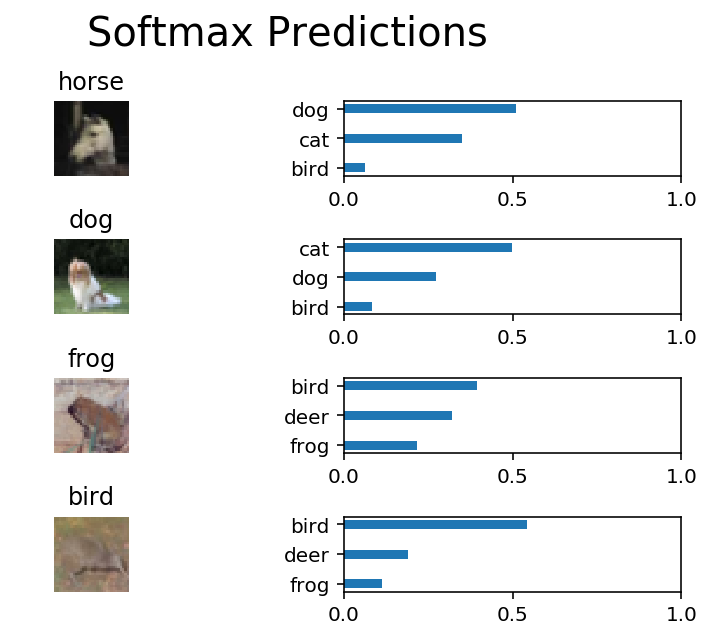

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## Why 50-80% Accuracy?
You might be wondering why you can't get an accuracy any higher. First things first, 50% isn't bad for a simple CNN.  Pure guessing would get you 10% accuracy. That's because there are many more techniques that can be applied to your model and we recemmond that once you are done with this project, you explore!

## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook.  Save the notebook file as "image_classification.ipynb" and save it as a HTML file under "File" -> "Download as".  Include the "helper.py" and "problem_unittests.py" files in your submission.